Here we implement adaptive filters using recursive least squares (RLS) and least mean squares (LMS) updates. We place our adaptive filters in cascade with the unknown system to invert the channel and recover the source signal. 

Consider an LTI system with unknown impulse response $ h[n] $. We pick a guess $ \hat{h}[n] $ for the channel and update the filter taps of our estimate at each epoch in accordance with recursive least squares (or LMS).

Recursive least squares typically converges extremely quickly.

Implemented by reference to http://www.cs.tut.fi/~tabus/course/ASP/LectureNew10.pdf.

The algorithm relies on Woodbury's matrix inversion lemma: 

$$  (A + BCD)^{−1} = A^{−1} - A^{-1}B(C^{-1} + DA^{-1}B)^{-1}DA^{-1}. $$

In [1]:
import math
import scipy
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def random_walk(N, sigma):
    temp = np.random.normal(0, sigma, N)
    x = np.cumsum(temp)
    return(x)

In [3]:
# parameters
M = 16      # filter order
T = 10000   # signal duration
eps = 1e-6  # tolerance

# impulse response of LTI system 
h = np.array([0.05, 0.05, 0.1, 0.7, 0.15, 0.05])
h = h / sum(h)

# signal generation
seed = 13
sigma = 0.2
s1 = random_walk(T, sigma)
ma_filter = 1/10 * np.ones(10)
s2 = scipy.signal.convolve(s1, ma_filter, 'same')
s = s2 / max(abs(s2))
#s = np.random.randint(2, size=T)
x = scipy.signal.convolve(s, h, 'same')
n = np.random.normal(0,0.05,T)
u = x + n

# desired signal
delay = 5
d = np.concatenate((np.zeros(delay + 1), s[delay:]))

# adaptive filter
delta = 100 * np.var(u)
l = 0.97
w = np.matrix(np.zeros(M)).T
P = delta * np.matlib.identity(M)
e = np.zeros(T)

In [4]:
# RLS training
y = np.zeros(T)
for t in range(M, T-5000):
    
    # input signal
    u_t = np.matrix(np.flip(u[t-M : t], axis=0)).T
    
    # updates
    num_k = np.power(l, -1) * (P * u_t)
    den_k = 1 + np.power(l, -1) * u_t.T * P * u_t
    k = num_k / den_k 
    
    y[t] = u_t.T * w
    e[t] = d[t] - y[t]
    a = e[t]
    
    # weight update
    w = w + k * a
    
    # matrix update
    P = np.power(l, -1) * P -np.power(l, -1) * k * u_t.T * P

## LMS

In [5]:
# add white gaussian noise to achieve desired signal-to-noise ratio in dB
def add_wgn(x, snr):
    N = len(x)
    e_x = np.mean(np.power(x, 2))
    e_n = e_x / np.power(10, snr/10)
    mu, sigma = 0, np.sqrt(e_n)
    n = np.random.normal(mu, sigma, N)
    return x + n

In [6]:
# parameters
M = 16     # filter order
T = 50000  # signal duration
eps = 1e-5 # tolerance

# system definition
h = np.array([1, 2, 8, 4, 2])
h = h / sum(h)

# signal generation
seed = 13
sigma = 1
s1 = random_walk(T, sigma)
ma_filter = 1/10 * np.ones(10)
s2 = scipy.signal.convolve(s1, ma_filter, 'same')
s = s2 / max(abs(s2))
x = scipy.signal.convolve(s, h, 'same')
snr = 20
u = add_wgn(x, snr)

# desired signal
delay = 5
d = np.concatenate((np.zeros(delay + 1), s[delay:]))

In [7]:
# LMS training (gradient descent update)
M = 15
mu = 1e-5
w = 1/M * np.ones(M)
u_t = np.zeros(M)
e = np.zeros(T)
y = np.zeros(T)

for t in range(M, T):
    u_t = np.flip(u[t-M : t], axis=0)
    y[t] = np.dot(u_t, w)
    e[t] = d[t] - y[t]
    w = w + mu * e[t] * u_t

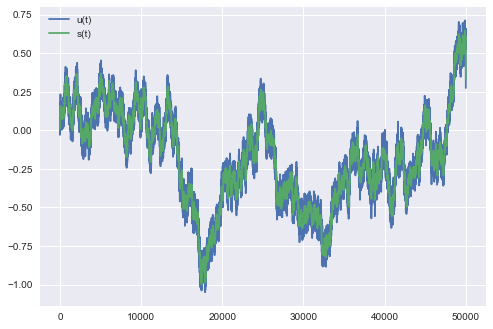

In [8]:
plt.plot(u, label='u(t)')
plt.plot(s, label='s(t)')
plt.legend()
plt.show()

In [9]:
# assess performance
dT = 1000
ind1 = T - 2 * dT
ind2 = T - dT

d_test = d[ind1 : ind2]
u_test = u[ind1 : ind2]

w_vec = np.array(w).squeeze()
y_test = scipy.signal.convolve(u_test, w_vec, 'same')

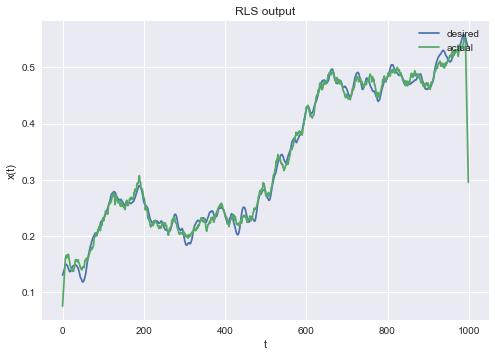

In [10]:
# plot RLS output
plt.title('RLS output')
plt.ylabel('x(t)')
plt.xlabel('t')
plt.plot(d_test, label='desired')
plt.plot(y_test, label='actual')
plt.legend(loc=1)
plt.show()